## This notebook is used for assessing the MassQL query for identifying **carnitine structures**
(original notebook content: v_carnitine_massql_query_for_manuscript_REDO-inchikey-Copy1.ipynb)

---

### About the process
We isolate unique structures from MS/MS spectra for venn diagram assessment of MassQL Queries as follows:

- Identify unique InchIKey first blocks associated with each MS/MS spectra (M+H adducts)
- SMILES metadata in GNPS for each MS/MS spectra were used to identify the associated compound structure using RDKit
- MS/MS spectra without structural information were removed
- Identify unique InchIKey first blocks to ignore stereochemistry and identify a single, generalized structure described by one of the MS/MS spectra identified in GNPS Libraries

---
### Section 1: Read input data
- carnitine metadata in GNPS Library **identified by substructure** 
- carnitine metadata in GNPS Library **identified by annotation**
- cleaned MassQL query output

### Section 2: Identify unique structures in **substructure-identified** carnitine data
- identify InChIKeys and InChIKey first blocks from SMILES metadata
- identify unique InChIkey first blocks
- filter dataframe to only include data for unique InChIkey first blocks

### Section 3: Identify unique structures in **annotation-identified** carnitine data
- get list of spectrum_id to make USI link for **MS/MS identified by library annotation search without structural metadata** https://gnps2.org/ workflow (createusi_markdown_workflow) **(SI Data 6)**
- identify InChIKeys and InChIKey first blocks from SMILES metadata
- identify unique InChIkey first blocks
- filter dataframe to only include data for unique InChIkey first blocks

### Section 4: Identify unique structures in MassQL query data 
- remove rows that do not contain SMILES information in 'Smiles' column
- identify InChIKeys and InChIKey first blocks from SMILES metadata
- identify unique InChIkey first blocks
- filter dataframe to only include data for unique InChIkey first blocks

**NOTE** The purpose of identifying unique InChIkey first blocks is to ignore stereochemistry and identify a single, generalized structure described by one of the MS/MS spectra identified in GNPS Libraries **(See SI Note 5)**.

---
# Venn Diagram Sections
---
## MassQL vs Library Annotation search
### Section 5: **Unique Structures** - **MassQL** vs **Annotation search**
- venn diagram comparing unique structures identified by MassQL query vs annotation search **(Figure 3a)**

### Section 6: **MS/MS** - **MassQL** vs **Annotation search**
- venn diagram comparing MS/MS identified by MassQL query vs annotation search **(SI Figure 1a)**

### Section 7: **MS/MS** - **MassQL** vs **Annotation search MS/MS with structural information**
- venn diagram comparing MS/MS identified by MassQL query vs annotation search MS/MS with structural information

#### - explanation of Venn diagrams
#### - get list of spectrum_id to make USI link for **MS/MS identified by MassQL and library annotation search** https://gnps2.org/ workflow (createusi_markdown_workflow) **(SI Data 3)**

---
## Library Annotation search vs substructure search
### Section 8: **Unique Structures** - **Annotation search** vs **Substructure search**
- venn diagram comparing unique structures identified by annotation search vs substructure search **(SI Figure 1b)**

### Section 9: **MS/MS** - **Annotation search** vs **Substructure search**
- venn diagram for visualizing unique MS/MS captured by annotation and substructure search

#### - explanation of Venn diagrams
#### - get list of spectrum_id to make USI link for **MS/MS identified by library annotation search and substructure search** https://gnps2.org/ workflow (createusi_markdown_workflow) **(SI Data 4)**
#### - get list of spectrum_id to make USI link for **MS/MS exclusively identified by library annotation search and not substructure search** https://gnps2.org/ workflow (createusi_markdown_workflow) **(SI Data 5)**

---
# Sections for drawing unique structures desrcibed by Venn Diagrams
### Section 10: Inner structures captured by **MassQL query** and **ANNOTATION identified carnitines** (associated with Section 5)
- identify InChIkey first blocks captured by BOTH sets
- match InChIkey first blocks with metadata to draw and visualize structures
- identify spectra associated with inner structures
- draw structures with associated InChIkey first blocks and example spectrum_id **(SI Figure 2a)**

### Section 11: Outer structures **ONLY** captured by **annotation search** (associated with Section 8)
- identify InChIkey first blocks only captured by annotation
- identify spectra associated with outer substructure structures
- draw structures with associated InChIkey first blocks and example spectrum_id **(SI Figure 2b)**

## Input files needed for the Notebook
1. Dataframe output of carnitine metadata in GNPS Library from **substructure_search_identify_carnitine.ipynb**
2. Dataframe output of carnitine metadata in GNPS Library from **annotation_search_identify_carnitine.ipynb**
3. Cleaned MassQL query output from **shape_carnitine_msql_output.ipynb**

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import pandas as pd

# for plotting venn diagrams
import matplotlib_venn
from matplotlib_venn import venn2

## Section 1: Read input data

#### read **substructure-identified** carnitine GNPS Library data

In [2]:
# from substructure_search_identify_carnitine.ipynb
library_df_w_carnitine_substruc = pd.read_csv('/home/jovyan/work/notebooks/outputs/library_df_w_carnitine_substruc.csv', sep=',')

#### read **annotation-identified** carnitine GNPS Library data

In [3]:
# from annotation_search_identify_carnitine.ipynb
library_df_w_carnitine_name = pd.read_csv('/home/jovyan/work/notebooks/outputs/library_df_carnitine_case_insen_M+H.csv', sep=',')

#### read MassQL output data

In [4]:
# from shape_carnitine_msql_output.ipynb
massql_query_output_matched = pd.read_csv('/home/jovyan/work/notebooks/outputs/massql_carnitine_query_peaks_nl_output_matched_for_venn_diagram.csv', sep=',')

In [5]:
massql_query_output_matched = massql_query_output_matched.replace(np.nan, 'N/A')

## Section 2: Identify unique structures in **substructure identified** carnitines

In [6]:
# derive InChIkey first blocks from 'InChIKey_smiles' column data
library_df_w_carnitine_substruc['first_block'] = [item.split('-')[0] for item in library_df_w_carnitine_substruc['InChIKey_smiles']]

In [7]:
# number of carnitine MS/MS spectra (identified by substructure) with M+H adducts
len(library_df_w_carnitine_substruc)

349

#### Identify InChIKeys and InChIKey first blocks from SMILES metadata
---
##### **Variables**
- smiles --> SMILES from "Smiles" column for a row in library_df_w_all_di
- mol --> molecule constructed from SMILES string (held in smiles variable) using RDKit
- inchikey --> inchikey constructed from molecule (held in mol variable) using RDKit
- inchikey_first_block --> inchikey_first_block derived from inchikey (held in inchikey variable)

In [8]:
library_df_w_carnitine_substruc_SMILES_INCHIKEY = {}

In [9]:
for x,y in enumerate(library_df_w_carnitine_substruc.Smiles.unique()):
    smiles = y
    mol = Chem.MolFromSmiles(y)
    inchikey = Chem.MolToInchiKey(mol)
    inchikey_first_block = inchikey.split('-')[0]
    
    library_df_w_carnitine_substruc_SMILES_INCHIKEY[x] = [smiles, mol, inchikey, inchikey_first_block]

In [10]:
# make dataframe from dictionary
library_df_w_carnitine_substruc_SMILES_INCHIKEY_df = pd.DataFrame.from_dict(library_df_w_carnitine_substruc_SMILES_INCHIKEY, orient='index',
                       columns=['smiles', 'mol', 'inchikey', 'inchikey_first_block'])

#### Need to identify **unique** InChIkey first blocks
- library_df_w_carnitine_substruc_SMILES_INCHIKEY_df still includes inchikey_first_block repeats

In [11]:
# identify unique InChIkey first blocks by counting first instance
unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df = []

for item in library_df_w_carnitine_substruc_SMILES_INCHIKEY_df.inchikey_first_block: 
    if item not in unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df: 
        unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df.append(item) 
        
len(unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df)

28

#### Filter library_df_w_carnitine_substruc_SMILES_INCHIKEY_df to only include unique InChIkey first blocks

In [12]:
library_df_w_carnitine_substruc_SMILES_INCHIKEY_df_no_dup = library_df_w_carnitine_substruc_SMILES_INCHIKEY_df.drop_duplicates(subset=['inchikey_first_block'])

## Section 3: Identify unique structures in **annotation identified** carnitines

In [13]:
# derive InChIkey first blocks from 'InChIKey_smiles' column data
library_df_w_carnitine_name['first_block'] = [item.split('-')[0] for item in library_df_w_carnitine_name['InChIKey_smiles']]

In [14]:
# number of carnitine MS/MS spectra (identified by annotation) with M+H adducts
len(library_df_w_carnitine_name)

387

In [15]:
# number of rows from annotation search output without SMILES data in 'Smiles' column
len(library_df_w_carnitine_name.dropna(subset=['Smiles']))

# output analysis: 376 MS/MS have structural information (SMILES metadata) --> 11 MS/MS don't have structural information

376

#### get list of spectrum_id of MS/MS identified by annotation search that do not have structural information

In [16]:
USI_link_beginning = 'mzspec:GNPS:GNPS-LIBRARY:accession:'

In [17]:
spectra_annot_search_no_struct_info = set(library_df_w_carnitine_name.spectrum_id) - set(library_df_w_carnitine_name.dropna(subset=['Smiles']).spectrum_id)

In [18]:
full_usi_spectra_annot_search_no_struct_info = [USI_link_beginning + spectrum_id for spectrum_id in spectra_annot_search_no_struct_info]

In [19]:
usi_spectra_annot_search_no_struct_info = pd.DataFrame(full_usi_spectra_annot_search_no_struct_info, columns=['usi'])

In [409]:
# used in SI Data 6
usi_spectra_annot_search_no_struct_info.to_csv("carnitine_annot_search_no_struct_info_USI.csv")

#### Identify InChIKeys and InChIKey first blocks from SMILES metadata
---
##### **Variables**
- smiles --> SMILES from "Smiles" column for a row in library_df_w_all_di
- mol --> molecule constructed from SMILES string (held in smiles variable) using RDKit
- inchikey --> inchikey constructed from molecule (held in mol variable) using RDKit
- inchikey_first_block --> inchikey_first_block derived from inchikey (held in inchikey variable)

In [20]:
library_df_w_carnitine_name_SMILES_INCHIKEY = {}

In [21]:
for x,y in enumerate(library_df_w_carnitine_name['Smiles'].dropna().unique()):
    smiles = y
    mol = Chem.MolFromSmiles(y)
    inchikey = Chem.MolToInchiKey(mol)
    inchikey_first_block = inchikey.split('-')[0]
    
    library_df_w_carnitine_name_SMILES_INCHIKEY[x] = [smiles, mol, inchikey, inchikey_first_block]

In [22]:
# make dataframe from dictionary
library_df_w_carnitine_name_SMILES_INCHIKEY_df = pd.DataFrame.from_dict(library_df_w_carnitine_name_SMILES_INCHIKEY, orient='index',
                       columns=['smiles', 'mol', 'inchikey', 'inchikey_first_block'])

#### Need to identify **unique** InChIkey first blocks
- library_df_w_carnitine_name_SMILES_INCHIKEY_df still includes inchikey_first_block repeats

In [23]:
# identify unique InChIkey first blocks by counting first instance
unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df = []

for item in library_df_w_carnitine_name_SMILES_INCHIKEY_df.inchikey_first_block: 
    if item not in unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df: 
        unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df.append(item) 
        
len(unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df)

30

#### Filter library_df_w_all_di_SMILES_INCHIKEY_df to only include unique InChIkey first blocks

In [24]:
library_df_w_carnitine_name_SMILES_INCHIKEY_df_no_dup = library_df_w_carnitine_name_SMILES_INCHIKEY_df.drop_duplicates(subset=['inchikey_first_block'])

## Section 4: Identify unique structures in **MassQL query** data

In [25]:
# derive InChIkey first blocks from 'InChIKey_smiles' column data
massql_query_output_matched['first_block'] = [item.split('-')[0] for item in massql_query_output_matched['InChIKey_smiles']]

In [26]:
# remove rows from MassQL query output without SMILES data in 'Smiles' column
massql_query_output_matched_SMILES = massql_query_output_matched[(massql_query_output_matched.Smiles != " ") & (massql_query_output_matched.Smiles != "N/A")]

In [27]:
# number of MS/MS spectra with M+H adducts
len(massql_query_output_matched_SMILES)

82

#### Identify InChIKeys and InChIKey first blocks from SMILES metadata
---
##### **Variables**
- smiles --> SMILES from "Smiles" column for a row in library_df_w_all_di
- mol --> molecule constructed from SMILES string (held in smiles variable) using RDKit
- inchikey --> inchikey constructed from molecule (held in mol variable) using RDKit
- inchikey_first_block --> inchikey_first_block derived from inchikey (held in inchikey variable)

In [28]:
massql_query_output_matched_SMILES_INCHIKEY = {}

In [29]:
for x,y in enumerate(massql_query_output_matched_SMILES.Smiles.unique()):
    smiles = y
    mol = Chem.MolFromSmiles(y)
    inchikey = Chem.MolToInchiKey(mol)
    inchikey_first_block = inchikey.split('-')[0]
    
    massql_query_output_matched_SMILES_INCHIKEY[x] = [smiles, mol, inchikey, inchikey_first_block]

In [30]:
# make dataframe from dictionary
massql_query_output_matched_SMILES_INCHIKEY_df = pd.DataFrame.from_dict(massql_query_output_matched_SMILES_INCHIKEY, orient='index',
                       columns=['smiles', 'mol', 'inchikey', 'inchikey_first_block'])

#### Need to identify **unique** InChIkey first blocks
- massql_query_output_matched_SMILES_INCHIKEY_df still includes inchikey_first_block repeats

In [31]:
# identify unique InChIkey first blocks by counting first instance
unique_massql_query_output_matched_SMILES_INCHIKEY_df = []

for item in massql_query_output_matched_SMILES_INCHIKEY_df.inchikey_first_block: 
    if item not in unique_massql_query_output_matched_SMILES_INCHIKEY_df: 
        unique_massql_query_output_matched_SMILES_INCHIKEY_df.append(item) 
        
len(unique_massql_query_output_matched_SMILES_INCHIKEY_df)

21

#### Filter massql_query_output_matched_SMILES_INCHIKEY_df to only include unique InChIkey first blocks

In [32]:
massql_query_output_matched_SMILES_INCHIKEY_df_no_dup = massql_query_output_matched_SMILES_INCHIKEY_df.drop_duplicates(subset=['inchikey_first_block'])

## Venn Diagram Sections

### Section 5: Unique Structures - MassQL Query vs Annotation search

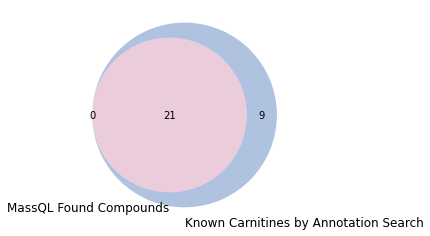

In [33]:
# Figure used for Figure 3a
venn2([set(unique_massql_query_output_matched_SMILES_INCHIKEY_df),
       set(unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df)],
      set_colors=('#ef5039','#3967b2'),
      set_labels = ('MassQL Found Compounds','Known Carnitines by Annotation Search' ))

### Section 6: MS/MS - MassQL Query vs Annotation search

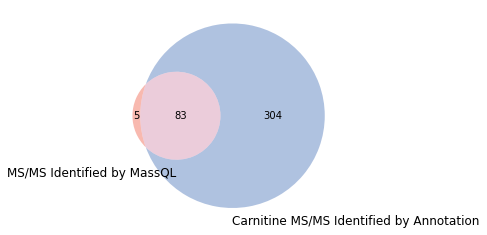

In [34]:
# Figure used for SI Figure 1a
venn2([set(massql_query_output_matched['spectrum_id'].dropna().unique()),
       set(library_df_w_carnitine_name['spectrum_id'].dropna().unique())],
      set_colors=('#ef5039','#3967b2'),
      set_labels = ('MS/MS Identified by MassQL', 'Carnitine MS/MS Identified by Annotation'))

### Section 7: MS/MS - **MassQL** vs **Annotation search MS/MS with structural information**

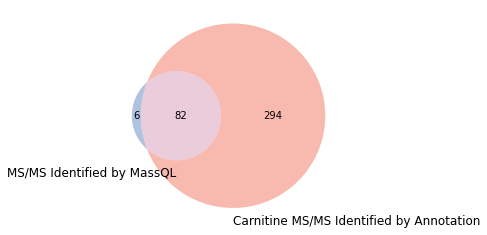

In [35]:
# figure for visualizing unique MS/MS captured by MassQL and annotation search MS/MS with structural information
venn2([set(massql_query_output_matched['spectrum_id'].dropna().unique()),
       set(library_df_w_carnitine_name.dropna(subset=['Smiles'])['spectrum_id'].unique())],
      set_colors=('#3967b2','#ef5039'),
      set_labels = ('MS/MS Identified by MassQL', 'Carnitine MS/MS Identified by Annotation'))

#### understanding the MassQL crescents in Section 6 (5 MS/MS) and 7 (6 MS/MS)

In [36]:
# used for SI Data 1
# spectrum_id of MS/MS that are exclusively identified by MassQL query (from section 6)
outer_massQL_query = set(massql_query_output_matched['spectrum_id'].dropna().unique()) - set(library_df_w_carnitine_name['spectrum_id'].dropna().unique())

# outer_massQL_query does not have Smiles metadata (no structural information) --> use Compound_Name to determine they are not carnitines
massql_query_output_matched[massql_query_output_matched['spectrum_id'].isin(outer_massQL_query)][['spectrum_id','Compound_Name','Smiles']]

,spectrum_id,Compound_Name,Smiles
54,CCMSLIB00004718368,"(2S,3R,4S,5S,6R)-2-[(2R,3R,4S,5S,6R)-4,5-dihyd...",N/A
55,CCMSLIB00004718427,"9,13-Dimethyl-17-oxo-14-(5-oxo-2,5-dihydro-3-f...",N/A
56,CCMSLIB00004719010,"6-[[(2R,3R,6aR,6bS,8aS,12aS,14bR)-2-hydroxy-4,...",N/A
57,CCMSLIB00004719080,"[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxym...",N/A
59,CCMSLIB00004719897,Cholic Acid,N/A


In [37]:
# spectrum_id of MS/MS identified by MassQL query (from Section 7)
massQL_query_no_struct_info =set(massql_query_output_matched.spectrum_id) - set(massql_query_output_matched_SMILES.spectrum_id)

# spectrum_id of MS/MS that doesn't have structural information and but is identified by annotation search and MassQL query in Section 6
massQL_query_no_struct_info - outer_massQL_query

{'CCMSLIB00004719808'}

### What Sections 5, 6, and 7 tell us
- 21 unique structures were identified by MassQL and library annotation search
- 9 unique structures are exlusively identified by library annotation search

- 5 MS/MS are exclusively identified by MassQL and don't have structural information --> use Compound_Name to deduce they are not carnitines
- 83 MS/MS are identified by both MassQL and library annotation search
- only 82 of those MS/MS have structural information; therefore, those 82 MS/MS describe the 21 unique structures captured by both search methods
- we know the library annotation search contains 376 MS/MS with structural information; therefore, the 9 unique structures exclusively captured by library annotation search are described by 294 MS/MS

#### get list of spectrum_id of MS/MS identified by MassQL query and library annotation search to make USI links

In [38]:
full_usi_inner_all = [USI_link_beginning + spectrum_id for spectrum_id in massql_query_output_matched_SMILES.spectrum_id.to_list()]

In [39]:
usi_inner_all = pd.DataFrame(full_usi_inner_all, columns=['usi'])

In [ ]:
# used in SI Data 3
usi_inner_all.to_csv("inner_carnitine_substruct_msql_USI_all.csv")

### Section 8: Unique Structures - Annotation search vs Substructure search

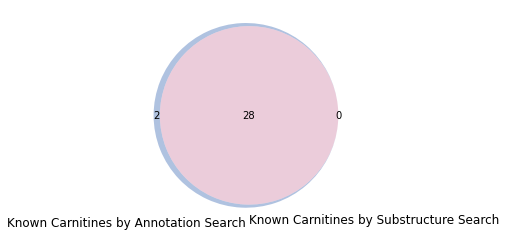

In [40]:
# Figure used for SI Figure 1b
venn2([set(unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df),
       set(unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df)],
      set_colors=('#3967b2','#ef5039'),
      set_labels = ('Known Carnitines by Annotation Search','Known Carnitines by Substructure Search'))

### Section 9: MS/MS - **Annotation search** vs **Substructure search**

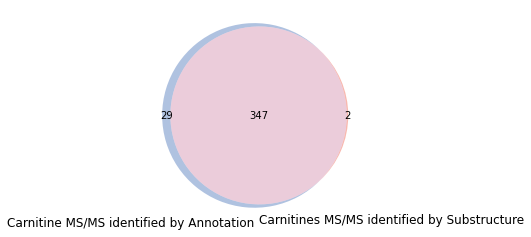

In [41]:
# figure for visualizing unique MS/MS captured by annotation and substructure search
venn2([set(library_df_w_carnitine_name.dropna(subset=['Smiles'])['spectrum_id'].unique()),
       set(library_df_w_carnitine_substruc['spectrum_id'].dropna().unique())],
      set_colors=('#3967b2','#ef5039'),
      set_labels = ('Carnitine MS/MS identified by Annotation','Carnitines MS/MS identified by Substructure'))

In [42]:
# InChIKey first blocks that describe the structures identified by both search methods
first_block_inner_name_substruc = list(set(unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df).intersection(unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df))

In [43]:
# validation that all MS/MS in library_df_w_carnitine_substruc describe the structures in first_block_inner_name_substruc
len(library_df_w_carnitine_substruc[library_df_w_carnitine_substruc['first_block'].isin(first_block_inner_name_substruc)])

349

In [45]:
# spectrum id for the 2 MS/MS exclusively captured by substructure search
set(library_df_w_carnitine_substruc['spectrum_id'].dropna().unique()) - set(library_df_w_carnitine_name.dropna(subset=['Smiles'])['spectrum_id'].unique())

{'CCMSLIB00006674116', 'CCMSLIB00006674120'}

### What Sections 8 and 9 tell us
- 28 unique structures were identified by library annotation and substructure search
- 2 unique structures are exlusively identified by library annotation search

- 29 MS/MS identified by library search annotation describe the 2 unique structure sexlusively identified by library annotation search
- 347 MS/MS describe the 28 unique structures were identified by library annotation and substructure search
- 2 MS/MS exclusively identified by substructure search also describe one of the 28 unique structures

#### get list of spectrum_id of MS/MS identified by annotation and substructure search to make USI links

In [46]:
full_usi_inner_substruct_annot = [USI_link_beginning + spectrum_id for spectrum_id in library_df_w_carnitine_substruc.spectrum_id.to_list()]

In [47]:
usi_inner_substruct_annot = pd.DataFrame(full_usi_inner_substruct_annot, columns=['usi'])

In [ ]:
# used in SI Data 4
usi_inner_substruct_annot.to_csv("inner_carnitine_substruct_annot_USI_all.csv")

# show all 349, though spectra CCMSLIB00006674116 and CCMSLIB00006674120 are only identified by substructure search

#### get list of spectrum_id of MS/MS identified by annotation search that describes the 2 structures

In [51]:
spectra_for_2_structs_annotation_search = set(library_df_w_carnitine_name.dropna(subset=['Smiles'])['spectrum_id'].unique()) - set(library_df_w_carnitine_substruc['spectrum_id'].dropna().unique())

In [52]:
full_usi_spectra_for_2_structs_annotation_search = [USI_link_beginning + spectrum_id for spectrum_id in spectra_for_2_structs_annotation_search]

In [53]:
usi_spectra_for_2_structs_annotation_search = pd.DataFrame(full_usi_spectra_for_2_structs_annotation_search, columns=['usi'])

In [ ]:
# used in SI Data 5
usi_spectra_for_2_structs_annotation_search.to_csv("two_carnitine_annot_search_USI.csv")

## Sections for drawing unique structures described by Venn diagrams

### Section 10: Inner structures captured by **MassQL query** and **ANNOTATION identified carnitines**
- associated with Venn diagram in Section 5

#### Identify InChIkey first blocks captured by BOTH sets

In [54]:
# comparing list of unique InChIkey first blocks to identify inner set of shared structures found by both methods
inner = [value for value in unique_massql_query_output_matched_SMILES_INCHIKEY_df if value in unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df]

In [55]:
# number of shared InChIkey first blocks
len(inner)

21

#### match InChIkey first blocks with metadata to draw and visualize structures

In [56]:
# match shared InChIkey first blocks with metadata describing smiles, mol, inchikey, and inchikey_first_block data
inner_name_df_examples = library_df_w_carnitine_name_SMILES_INCHIKEY_df_no_dup[library_df_w_carnitine_name_SMILES_INCHIKEY_df_no_dup['inchikey_first_block'].isin(inner)]

#### Identify example spectra associated with inner structures
- for visualizing structure with InChIkey first blocks and example spectrum_id

##### Isolate spectra with diagnostic peaks
Because the carnitines identified in library_df_w_carnitine_name were found using annotation, we cannot guarantee their associated MS/MS have the diagnotic peaks we are looking for. For the sake of figure generation for the manuscript and to ensure the example spectra provided are consistent with what is expected, the below code filters MS/MS for those that contain the expected diagnostic peaks.

In [57]:
lib_spectra_with_85_60_peaks = []
for x,y in library_df_w_carnitine_substruc.iterrows():
    peaks = library_df_w_carnitine_substruc.peaks_json[x]
    if peaks.find('[85.0') != -1 and peaks.find('[60.0') != -1:
        lib_spectra_with_85_60_peaks.append(library_df_w_carnitine_substruc.spectrum_id[x])

In [58]:
# list of spectrum_id that describe MS/MS that have the expected diagnostic peaks (216 MS/MS out of the 349 MS/MS)
len(lib_spectra_with_85_60_peaks)

216

##### MS/MS spectra that describe inner structures but are **NOT confirmed to have all diagnostic peaks**

In [59]:
library_df_w_carnitine_name_inner =  library_df_w_carnitine_name[library_df_w_carnitine_name['Smiles'].isin(inner_name_df_examples.smiles)].reset_index()

In [60]:
library_df_w_carnitine_name_inner_no_dup = library_df_w_carnitine_name_inner.drop_duplicates(subset=['Smiles'])

In [61]:
len(library_df_w_carnitine_name_inner_no_dup)

21

##### MS/MS spectra that describe inner structures **AND have all diagnostic peaks**

In [62]:
library_df_w_carnitine_name_inner_no_dup_with_peaks = library_df_w_carnitine_name_inner_no_dup[library_df_w_carnitine_name_inner_no_dup['spectrum_id'].isin(lib_spectra_with_85_60_peaks)]

##### identify if there are any missing spectrum_id from the expected 21 inner captured structures due to lack of diagnostic peaks
Substract the spectrum_id of MS/MS spectra that describe inner structures but are **NOT confirmed to have all diagnostic peaks** from MS/MS spectra that describe inner structures **AND have all diagnostic peaks**.

In [63]:
# spectrum_id with missing diagnostic peaks
set(library_df_w_carnitine_name_inner_no_dup.spectrum_id) - set(library_df_w_carnitine_name_inner_no_dup_with_peaks.spectrum_id)

{'CCMSLIB00003137514',
 'CCMSLIB00003138249',
 'CCMSLIB00003138757',
 'CCMSLIB00004684226',
 'CCMSLIB00004684227',
 'CCMSLIB00005788025',
 'CCMSLIB00006674033'}

##### identify what structure corresponds to spectrum_id (using InChIKey data)
For the sake of figure generation and providing consistent examples in the manuscript, we will use spectral data from massql query output as the example MS/MS for the same structure described by the InChIKey first blocks.

In [64]:
# InChIKey first blocks associated with spectrum_id with missing diagnostic peaks
need_from_massql = list(set(library_df_w_carnitine_name_inner_no_dup.first_block) - set(library_df_w_carnitine_name_inner_no_dup_with_peaks.first_block))

##### shaping data to draw structures with associated InChIkey first blocks and example spectrum_id
To ensure all structures described in inner_name_df_examples have appropriate structural and spectral data, we must merge the data from library_df_w_carnitine_name_inner_no_dup_with_peaks describing 14 MS/MS with the 7 MS/MS from the MassQL dataset.

---
InChIKey structural data is included to facilitate the final merge with inner_name_df_examples.

In [65]:
# spectral and structural data describing 14 out of the 21 structures in inner_name_df_examples
library_name_inner_to_merge = library_df_w_carnitine_name_inner_no_dup_with_peaks[['spectrum_id','InChIKey_smiles','first_block']]

In [66]:
# spectral and structural data describing 7 out of the 21 structures in inner_name_df_examples (first occurrence of need_from_massql in massql_query_output_matched_SMILES)
massql_name_inner_to_merge = massql_query_output_matched_SMILES[massql_query_output_matched_SMILES['first_block'].isin(need_from_massql)][['spectrum_id','InChIKey_smiles','first_block']].drop_duplicates(subset=['first_block'])

##### merge spectral and structural data

In [67]:
merged_inner_name = pd.concat([library_name_inner_to_merge, massql_name_inner_to_merge], ignore_index = True)

##### merge structural data with inner_name_df_examples on structrual (InChIkey first block) data

In [68]:
inner_name_df_examples_spectra_merged = pd.merge(inner_name_df_examples, merged_inner_name[['first_block','spectrum_id']], left_on='inchikey_first_block', right_on='first_block', how='left')

##### make legend describing InChIkey first blocks and spectrum_id to show under structure

In [69]:
legend_inner_name = [inchikey_first_block +" : "+ spec_id for inchikey_first_block,spec_id in zip(inner_name_df_examples_spectra_merged['inchikey_first_block'], inner_name_df_examples_spectra_merged['spectrum_id'])]

#### Draw structures with associated InChIkey first blocks and example spectrum_id

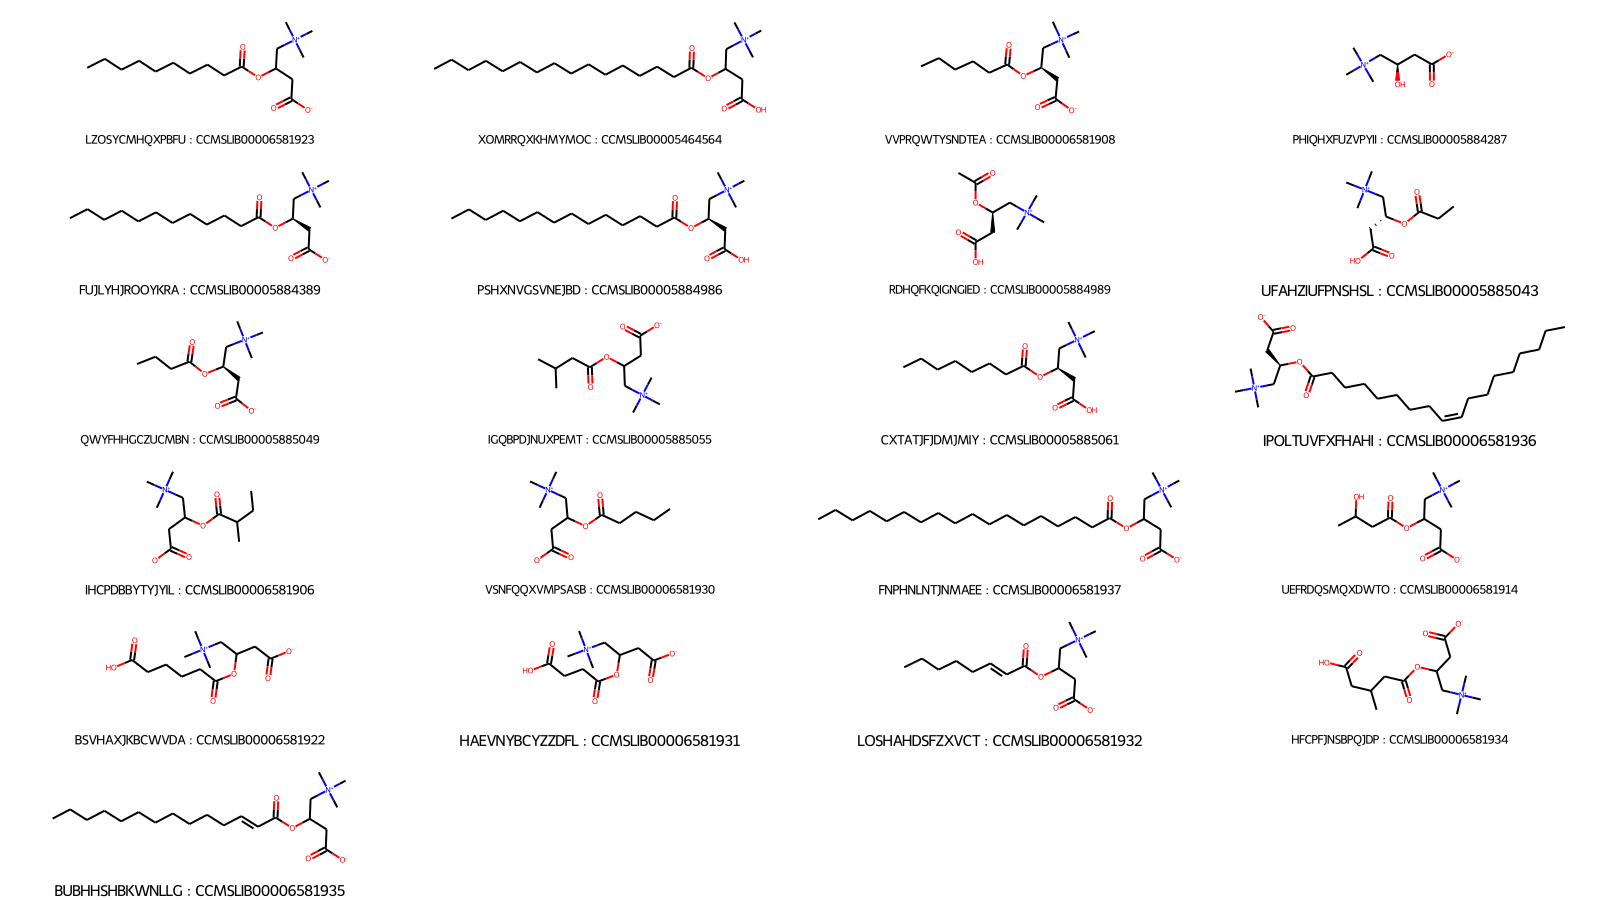

In [70]:
# used in SI Figure 2a
Draw.MolsToGridImage(inner_name_df_examples_spectra_merged.mol, molsPerRow = 4,subImgSize=(400,150), useSVG = False, maxMols=100,
                    legends=legend_inner_name)

### Section 11: Outer structures **ONLY** captured by **annotation search**
- associated with Venn diagram in Section 8

In [71]:
# InChIKey first blocks that describe the structures exclusively identified by library annotation search
first_block_only_annot = set(unique_library_df_w_carnitine_name_SMILES_INCHIKEY_df) - set(unique_library_df_w_carnitine_substruc_SMILES_INCHIKEY_df)

In [72]:
# identify structures exclusively identified by library annotation
outer_annot_search_only = library_df_w_carnitine_name_SMILES_INCHIKEY_df_no_dup[library_df_w_carnitine_name_SMILES_INCHIKEY_df_no_dup['inchikey_first_block'].isin(first_block_only_annot)]

#### Identify example spectra associated with outer structures exclusively identified by annotation search
- for visualizing structure with InChIkey first blocks and example spectrum_id

In [73]:
# spectra data associated with outer structures exclusively identified by annotation search
library_df_w_carnitine_name_outer_annot_search_only =  library_df_w_carnitine_name[library_df_w_carnitine_name['Smiles'].isin(outer_annot_search_only.smiles)]

In [74]:
library_df_w_carnitine_name_outer_annot_search_only_no_dup = library_df_w_carnitine_name_outer_annot_search_only.drop_duplicates(subset=['Smiles'])

##### merge structural data with outer_annot_search_only on structrual (InChIkey first block) data

In [75]:
outer_annot_search_only_library_merged = pd.merge(outer_annot_search_only, library_df_w_carnitine_name_outer_annot_search_only_no_dup[['first_block','spectrum_id']], left_on='inchikey_first_block', right_on='first_block', how='left')

##### make legend describing InChIkey first blocks and spectrum_id to show under structure

In [76]:
legend_outer_annot_only = [inchikey_first_block +" : "+ spec_id for inchikey_first_block,spec_id in zip(outer_annot_search_only_library_merged['inchikey_first_block'], outer_annot_search_only_library_merged['spectrum_id'])]

#### Draw structures with associated InChIkey first blocks and example spectrum_id

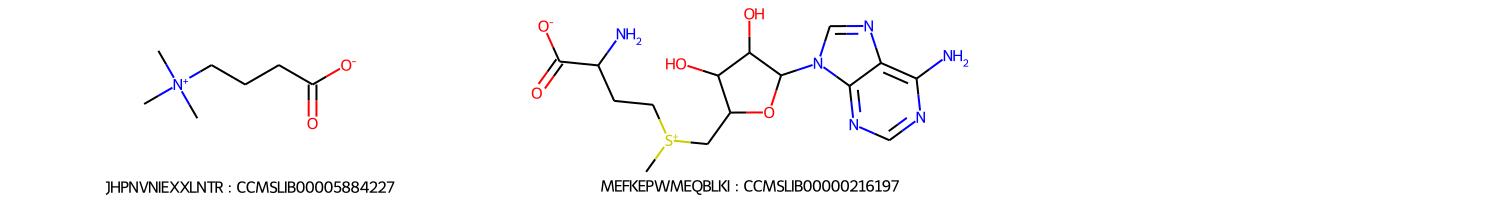

In [77]:
# used in SI Figure 2b
Draw.MolsToGridImage(outer_annot_search_only_library_merged.mol,subImgSize=(500,200), useSVG = False, maxMols=100,
                    legends=legend_outer_annot_only)